In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.autograd import Variable

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe'

import ta
from ta import add_all_ta_features
from ta.utils import dropna

### 1. Read and visualize dataset

In [2]:
datasets = ['ali', 'copper', 'lead', 'nickel', 'zinc']
dataset_idx = 2

In [3]:
dataset_file = "./Data/{}.csv".format(datasets[dataset_idx])
df = pd.read_csv(dataset_file, index_col=0)
df['date'] = pd.to_datetime(df['date'])
df[df.isna().any(axis=1)]

,date,PX_LAST,PX_HIGH,PX_LOW,PX_OPEN,PX_VOLUME
3788,2018-12-25,1987.0,1987.0,1987.0,1987.0,NaN
3792,2019-01-01,2010.5,2010.5,2010.5,2010.5,NaN


In [4]:
# Clean NaN values
df = dropna(df)
df.set_index('date', drop=True, inplace=True)
df.head()

,PX_LAST,PX_HIGH,PX_LOW,PX_OPEN,PX_VOLUME
date,,,,,
2004-01-02,738.0,741.0,728.0,728.0,413.0
2004-01-05,731.0,745.0,728.0,744.0,308.0
2004-01-06,731.0,743.0,730.0,740.0,140.0
2004-01-07,720.0,732.0,720.0,731.0,232.0
2004-01-08,745.0,745.0,714.0,725.0,123.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5444 entries, 2004-01-02 to 2025-07-18
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PX_LAST    5444 non-null   float64
 1   PX_HIGH    5444 non-null   float64
 2   PX_LOW     5444 non-null   float64
 3   PX_OPEN    5444 non-null   float64
 4   PX_VOLUME  5444 non-null   float64
dtypes: float64(5)
memory usage: 255.2 KB


In [6]:
window = 20

df['SMA'] = ta.trend.sma_indicator(df.PX_LAST, window=window, fillna=False)
df['EMA'] = ta.trend.ema_indicator(df.PX_LAST, window=window, fillna=False)
df['WMA'] = ta.trend.ema_indicator(df.PX_LAST, window=window, fillna=False)
df['HLC3'] = (df.PX_HIGH + df.PX_LOW + df.PX_LAST) / 3
df['ATR'] = ta.volatility.average_true_range(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, fillna=False)
df['UL'] = ta.volatility.ulcer_index(df.PX_LAST, window=window, fillna=False)

df['BBU'] = ta.volatility.bollinger_hband(df.PX_LAST, window=window, window_dev=2, fillna=False)
# df['BBM'] = ta.volatility.bollinger_mavg(df.PX_LAST, window=window, fillna=False) # same with SMA
df['BBL'] = ta.volatility.bollinger_lband(df.PX_LAST, window=window, window_dev=2, fillna=False)

df['DCU'] = ta.volatility.donchian_channel_hband(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, offset=0, fillna=False)
df['DCM'] = ta.volatility.donchian_channel_lband(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, offset=0, fillna=False)
df['DCL'] = ta.volatility.donchian_channel_mband(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, offset=0, fillna=False)

df['KCU'] = ta.volatility.keltner_channel_hband(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, window_atr=10, fillna=False, original_version=False)
# df['KCM'] = ta.volatility.keltner_channel_mband(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, window_atr=10, fillna=False, original_version=False) # same with EMA
df['KCL'] = ta.volatility.keltner_channel_lband(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, window_atr=10, fillna=False, original_version=False)

df['ROC'] = ta.momentum.roc(df.PX_LAST, window=window, fillna=False)
df['KST'] = ta.trend.kst(df.PX_LAST, roc1=10, roc2=15, roc3=20, roc4=30, window1=10, window2=10, window3=10, window4=15, fillna=False)
df['KST_SIG'] = ta.trend.kst_sig(df.PX_LAST, roc1=10, roc2=15, roc3=20, roc4=30, window1=10, window2=10, window3=10, window4=15, nsig=9, fillna=False)

df['Ichimoku_conversion'] = ta.trend.ichimoku_conversion_line(df.PX_HIGH, df.PX_LOW, window1=9, window2=26, visual=False, fillna=False)
df['Ichimoku_base'] = ta.trend.ichimoku_base_line(df.PX_HIGH, df.PX_LOW, window1=9, window2=26, visual=False, fillna=False)
df['Ichimoku_a'] = ta.trend.ichimoku_a(df.PX_HIGH, df.PX_LOW, window1=9, window2=26, visual=False, fillna=False)
df['Ichimoku_b'] = ta.trend.ichimoku_b(df.PX_HIGH, df.PX_LOW, window2=26, window3=52, visual=False, fillna=False)

df['MACD'] = ta.trend.macd(df.PX_LAST, window_slow=26, window_fast=12, fillna=False)
df['MACD_SIG'] = ta.trend.macd_signal(df.PX_LAST, window_slow=26, window_fast=12, window_sign=9, fillna=False)

df['MI'] = ta.trend.mass_index(df.PX_HIGH, df.PX_LOW, window_fast=9, window_slow=25, fillna=False)
df['CCI'] = ta.trend.cci(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, constant=0.015, fillna=False)

# df['PSARU'] = ta.trend.psar_up(df.PX_HIGH, df.PX_LOW, df.PX_LAST, step=0.02, max_step=0.2, fillna=True)
# df['PSARD'] = ta.trend.psar_down(df.PX_HIGH, df.PX_LOW, df.PX_LAST, step=0.02, max_step=0.2, fillna=True)

df['AROONU'] = ta.trend.aroon_up(df.PX_HIGH, df.PX_LOW, window=window, fillna=False)
df['AROOND'] = ta.trend.aroon_down(df.PX_HIGH, df.PX_LOW, window=window, fillna=False)

df['AO'] = ta.momentum.awesome_oscillator(df.PX_HIGH, df.PX_LOW, window1=5, window2=34, fillna=False)
df['KAMA'] = ta.momentum.kama(df.PX_LAST, window=window, pow1=2, pow2=30, fillna=False)

df['PPO'] = ta.momentum.ppo(df.PX_LAST, window_slow=26, window_fast=12, window_sign=9, fillna=False)
df['PPO_SIG'] = ta.momentum.ppo_signal(df.PX_LAST, window_slow=26, window_fast=12, window_sign=9, fillna=False)

df['PVO'] = ta.momentum.pvo(df.PX_VOLUME, window_slow=26, window_fast=12, window_sign=9, fillna=False)
df['PVO_SIG'] = ta.momentum.pvo_signal(df.PX_VOLUME, window_slow=26, window_fast=12, window_sign=9, fillna=False)

df['RSI'] = ta.momentum.rsi(df.PX_LAST, window=window, fillna=False)
df['Stochastic'] = ta.momentum.stoch(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, smooth_window=3, fillna=False)
df['TSI'] = ta.momentum.tsi(df.PX_LAST, window_slow=25, window_fast=13, fillna=False)
df['ADX'] = ta.trend.adx(df.PX_HIGH, df.PX_LOW, df.PX_LAST, window=window, fillna=False)
df['FI'] = ta.volume.force_index(df.PX_LAST, df.PX_VOLUME, window=window, fillna=False)

df['EMV'] = ta.volume.ease_of_movement(df.PX_HIGH, df.PX_LOW, df.PX_VOLUME, window=window, fillna=False)
df['EMV_SMA'] = ta.volume.sma_ease_of_movement(df.PX_HIGH, df.PX_LOW, df.PX_VOLUME, window=window, fillna=False)

df['MFI'] = ta.volume.money_flow_index(df.PX_HIGH, df.PX_LOW, df.PX_LAST, df.PX_VOLUME, window=window, fillna=False)
df['VPT'] = ta.volume.volume_price_trend(df.PX_LAST, df.PX_VOLUME, fillna=False)
df['VWAP'] = ta.volume.volume_weighted_average_price(df.PX_HIGH, df.PX_LOW, df.PX_LAST, df.PX_VOLUME, window=window, fillna=False)
df['CMF'] = ta.volume.chaikin_money_flow(df.PX_HIGH, df.PX_LOW, df.PX_LAST, df.PX_VOLUME, window=window, fillna=False)
df['OBV'] = ta.volume.on_balance_volume(df.PX_LAST, df.PX_VOLUME, fillna=False)

df.dropna(inplace=True)
df.head()

,PX_LAST,PX_HIGH,PX_LOW,PX_OPEN,PX_VOLUME,SMA,EMA,WMA,HLC3,ATR,...,TSI,ADX,FI,EMV,EMV_SMA,MFI,VPT,VWAP,CMF,OBV
date,,,,,,,,,,,,,,,,,,,,,
2004-02-27,888.0,890.0,885.0,890.0,43.0,850.75,850.020000,850.020000,887.666667,20.259698,...,33.741980,44.998082,-205.086592,6.976744e+07,5.794830e+07,67.614301,7.393853,854.305495,0.138956,436.0
2004-03-01,908.0,924.0,900.0,900.0,108.0,857.20,855.541905,855.541905,910.666667,21.046713,...,33.613963,44.744300,20.159750,5.444444e+08,8.119994e+07,66.118086,9.826285,861.011857,0.155938,544.0
2004-03-02,891.0,902.0,890.0,902.0,219.0,861.90,858.918866,858.918866,894.333333,20.894377,...,31.640732,44.229567,-336.331655,-8.767123e+07,7.278607e+07,62.291853,5.726065,864.535997,0.092694,325.0
2004-03-03,844.0,888.0,840.0,888.0,250.0,863.75,857.498022,857.498022,857.333333,22.399658,...,25.308240,42.592942,-1423.347688,-6.144000e+08,3.969362e+07,58.800891,-7.461365,865.251834,0.045516,75.0
2004-03-04,846.0,846.0,820.0,836.0,496.0,865.40,856.402972,856.402972,837.333333,22.579675,...,20.765745,40.664301,-1193.314575,-1.625000e+08,2.932881e+07,52.321330,-6.286009,864.782236,0.148286,571.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5404 entries, 2004-02-27 to 2025-07-18
Data columns (total 49 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PX_LAST              5404 non-null   float64
 1   PX_HIGH              5404 non-null   float64
 2   PX_LOW               5404 non-null   float64
 3   PX_OPEN              5404 non-null   float64
 4   PX_VOLUME            5404 non-null   float64
 5   SMA                  5404 non-null   float64
 6   EMA                  5404 non-null   float64
 7   WMA                  5404 non-null   float64
 8   HLC3                 5404 non-null   float64
 9   ATR                  5404 non-null   float64
 10  UL                   5404 non-null   float64
 11  BBU                  5404 non-null   float64
 12  BBL                  5404 non-null   float64
 13  DCU                  5404 non-null   float64
 14  DCM                  5404 non-null   float64
 15  DCL                 

### 2. Data processing for modeling

In [8]:
def create_sliding_window(data, feature_length, output_length, stride=1):
    X_list, y_list = [], []
    for i in range(len(data)):
      if (i + feature_length + output_length) < len(data):
        X_list.append(data.iloc[i:i+feature_length:stride, :].values)
        y_list.append(data.iloc[i+feature_length:i+feature_length+output_length:stride, 0])
    return np.array(X_list), np.array(y_list)

In [9]:
train_split = 0.95
n_train = int(train_split * len(df))
n_test = len(df) - n_train

feature_array = df.drop(columns=['PX_LAST', 'PX_HIGH', 'PX_LOW', 'PX_OPEN', 'PX_VOLUME']).values
target_array = df.PX_LAST.values

# Fit Scaler only on Training features
feature_scaler = MinMaxScaler()
feature_scaler.fit(feature_array[:n_train])
# Fit Scaler only on Training target values
target_scaler = MinMaxScaler()
target_scaler.fit(target_array[:n_train].reshape(-1, 1))

# Transfom on both Training and Test data
scaled_array = pd.DataFrame(feature_scaler.transform(feature_array),
                            columns=df.drop(columns=['PX_LAST', 'PX_HIGH', 'PX_LOW', 'PX_OPEN', 'PX_VOLUME']).columns)

feature_length = 30
output_length = 10
X, y = create_sliding_window(scaled_array, feature_length, output_length)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5133, 30, 44) (5133, 10) (231, 30, 44) (231, 10)


### 3. LSTM model

In [38]:
class BayesianLSTM(nn.Module):

    def __init__(self, n_features, output_length, batch_size):

        super(BayesianLSTM, self).__init__()

        self.batch_size = batch_size # user-defined

        self.hidden_size_1 = 128 # number of encoder cells
        self.hidden_size_2 = 32 # number of decoder cells
        self.stacked_layers = 2 # number of (stacked) LSTM layers for each stage
        self.dropout_probability = 0.2 # performance is generally stable across all ranges

        self.lstm1 = nn.LSTM(n_features,
                             self.hidden_size_1,
                             num_layers=self.stacked_layers,
                             batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size_1,
                             self.hidden_size_2,
                             num_layers=self.stacked_layers,
                             batch_first=True)

        self.fc = nn.Linear(self.hidden_size_2, output_length)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        hidden = self.init_hidden1(batch_size)
        output, _ = self.lstm1(x, hidden)
        output = F.dropout(output, p=self.dropout_probability, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        output = F.dropout(output, p=self.dropout_probability, training=True)
        # Important when lstm num_layers > 1
        output = output[:, -1, :] # take the last decoder cell's outputs
        y_pred = self.fc(output)
        return y_pred

    def init_hidden1(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        return hidden_state, cell_state

    def init_hidden2(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        return hidden_state, cell_state

    def predict(self, X):
        return self(torch.tensor(X, dtype=torch.float32)).view(-1).detach().numpy()

In [39]:
def training_loop(n_epochs, lstm, optimizer, loss_fn, X_train, y_train,
                  X_test, y_test):

    # Initialize a list to log training/validation losses
    train_loss_logger = []
    val_loss_logger = []

    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(torch.tensor(X_train, dtype=torch.float32)) # forward pass
        
        # calculate loss
        loss = loss_fn(outputs.view(-1), torch.tensor(y_train.flatten(), dtype=torch.float32))

        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

        # Log the training loss
        train_loss_logger.append(loss.item())
        
        # validation loss
        lstm.eval()
        test_preds = lstm(torch.tensor(X_test, dtype=torch.float32))
        test_loss = loss_fn(test_preds.view(-1), torch.tensor(y_test.flatten(), dtype=torch.float32))

        # Log the validation loss
        val_loss_logger.append(test_loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, train loss: {loss.item(): .5f}, test loss: {test_loss.item(): .5f}" )

    return train_loss_logger, val_loss_logger

#### 3.1 Define hyperparameters

In [40]:
n_features = scaled_array.shape[-1]

batch_size = 128
n_epochs = 2000
learning_rate = 1e-4

bayesian_lstm = BayesianLSTM(n_features=n_features,
                             output_length=output_length,
                             batch_size = batch_size)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(bayesian_lstm.parameters(), lr=learning_rate)

#### 3.2 Model training

In [41]:
train_loss_logger, val_loss_logger = training_loop(n_epochs=n_epochs,
                                                   lstm=bayesian_lstm,
                                                   optimizer=optimizer,
                                                   loss_fn=criterion,
                                                   X_train=X_train,
                                                   y_train=y_train,
                                                   X_test=X_test,
                                                   y_test=y_test)

Epoch: 0, train loss:  0.18128, test loss:  0.16413
Epoch: 10, train loss:  0.17442, test loss:  0.15714
Epoch: 20, train loss:  0.16730, test loss:  0.14974
Epoch: 30, train loss:  0.15831, test loss:  0.14028
Epoch: 40, train loss:  0.14507, test loss:  0.12644
Epoch: 50, train loss:  0.12409, test loss:  0.10444
Epoch: 60, train loss:  0.10175, test loss:  0.08063
Epoch: 70, train loss:  0.08597, test loss:  0.06408
Epoch: 80, train loss:  0.07292, test loss:  0.04784
Epoch: 90, train loss:  0.06239, test loss:  0.03831
Epoch: 100, train loss:  0.05429, test loss:  0.02803
Epoch: 110, train loss:  0.04807, test loss:  0.02281
Epoch: 120, train loss:  0.04408, test loss:  0.01852
Epoch: 130, train loss:  0.04238, test loss:  0.01586
Epoch: 140, train loss:  0.04079, test loss:  0.01404
Epoch: 150, train loss:  0.03877, test loss:  0.01380
Epoch: 160, train loss:  0.03595, test loss:  0.01346
Epoch: 170, train loss:  0.03144, test loss:  0.01378
Epoch: 180, train loss:  0.02523, test 

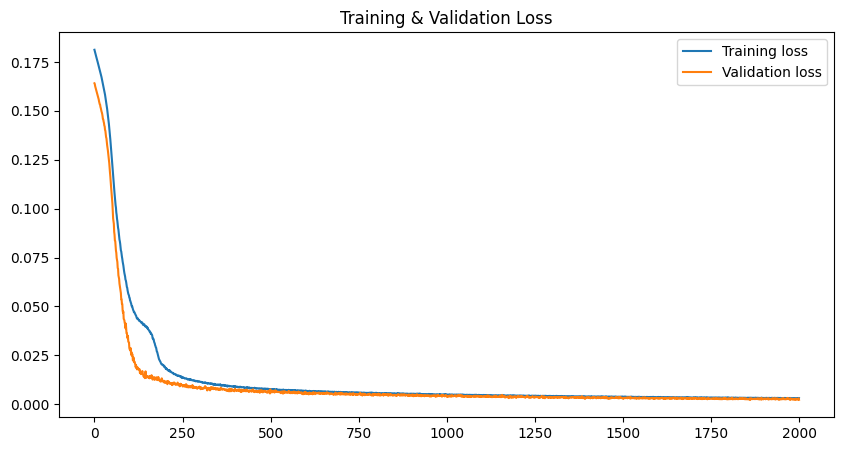

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_logger, label='Training loss')
plt.plot(val_loss_logger, label='Validation loss')
plt.title("Training & Validation Loss")
plt.legend()

# Save the figure as a PNG file
# plt.savefig("./Results/Loss.png")

plt.show()

### 4. Model prediction

In [17]:
def inverse_transform(y):
    return target_scaler.inverse_transform(y.reshape(-1, 1))

In [47]:
offset = feature_length + output_length

training_df = pd.DataFrame()
training_df['date'] = df.index[offset:n_train + offset:1]
training_predictions = bayesian_lstm.predict(X_train)[::10]
training_df['Close'] = inverse_transform(training_predictions)
training_df['source'] = 'Training Prediction'

training_truth_df = pd.DataFrame()
training_truth_df['date'] = training_df['date']
training_truth_df['Close'] = list(df['PX_LAST'].iloc[offset:n_train + offset:1])
training_truth_df['source'] = 'True Values'

testing_df = pd.DataFrame()
testing_df['date'] = df.index[n_train + offset::1]
testing_predictions = bayesian_lstm.predict(X_test)[::10]
testing_df['Close'] = inverse_transform(testing_predictions)
testing_df['source'] = 'Test Prediction'

testing_truth_df = pd.DataFrame()
testing_truth_df['date'] = testing_df['date']
testing_truth_df['Close'] = list(df['PX_LAST'].iloc[n_train + offset::1])
testing_truth_df['source'] = 'True Values'

evaluation = pd.concat([training_df,
                        testing_df,
                        training_truth_df,
                        testing_truth_df
                        ], axis=0)

In [48]:
fig = px.line(evaluation,
                 x="date",
                 y="Close",
                 color="source",
                 title="{} Price Over Time".format(datasets[dataset_idx]))
fig.show()

In [37]:
# 200 epochs results
fig = px.line(evaluation,
                 x="date",
                 y="Close",
                 color="source",
                 title="{} Price Over Time".format(datasets[dataset_idx]))
fig.show()